# Navy ICAS Data Analysis

The following code is an intial exploration of the Navy INCAS data.  Very little information is provided about the data or its collection, however it is known to contain anomalies.  The purpose of this project is to attempt to identify these anomalies and record the process followed to begin to estalbish standard procedures and methodologies to be utilized in future data analytics projects.

### Import packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Import complete data set for Class A, Ship 1, MRGs

Create function to import file to dataframe and convert datetime to datetime format

In [2]:
def readFileConvertdt(filename):
    df = pd.read_csv(filename)
    df['DateTime'] = pd.to_datetime(df.DateTime)
    return(df)

In [3]:
filename = 'data/classA_ship1_allMRG.csv'
A1_MRG_all = readFileConvertdt(filename)

In [156]:
A1_MRG_all.shape

(294926, 38)

In [20]:
A1_MRG_all.head()

DateTime  TURBINE INLET TEMP  TURB OVER TEMP  TURN GR ENGAGED  \
0 2016-07-25 13:30:16         1331.099976             0.0              0.0   
1 2016-07-25 13:30:19         1347.699951             0.0              0.0   
2 2016-07-25 13:30:22         1407.199951             0.0              0.0   
3 2016-07-25 13:30:25         1335.000000             0.0              0.0   
4 2016-07-25 13:30:33         1328.099976             0.0              0.0   

   TURN GR DISENGD  THRUST BRG TEMP   SUMP TEMP  SHAFT RPM  MOST RMT BRG PRES  \
0              1.0       102.400002  108.099998  17.000000          25.500000   
1              1.0       102.400002  108.099998  29.900000          26.400000   
2              1.0       102.400002  108.099998  40.200001          26.700001   
3              1.0       102.400002  108.099998  47.500000          26.799999   
4              1.0       102.400002  108.099998  56.200001          24.500000   

   LO HEADER TEMP    ...      BRG #17 TEMP  BRG #16 TEMP  BRG #15 TEMP  \
0      109.199997    ...        100.099998    101.800003    101.199997   
1      109.199997    ...        100.099998    101.800003    100.699997   
2      109.199997    ...        100.099998    101.800003    100.699997   
3      109.199997    ...        100.099998    101.800003    101.199997   
4      109.199997    ...        100.099998    101.800003    101.199997   

   BRG #14 TEMP  BRG #13 TEMP  BRG #12 TEMP  BRG #11 TEMP  BRG #10 TEMP  \
0    100.699997    100.099998    100.099998    100.699997    100.699997   
1    100.699997    100.099998     99.500000    100.699997    100.699997   
2    100.699997    100.099998    100.099998    100.699997    100.699997   
3    100.699997    100.099998     99.500000    100.699997    100.699997   
4    100.699997    100.099998    100.099998    100.699997    101.199997   

   BRG #1 TEMP  indicator  
0   101.800003       MRG1  
1   101.800003       MRG1  
2   101.800003       MRG1  
3   101.800003       MRG1  
4   101.800003       MRG1  

[5 rows x 38 columns]

In [158]:
A1_MRG_all.dtypes

DateTime              datetime64[ns]
TURBINE INLET TEMP           float64
TURB OVER TEMP               float64
TURN GR ENGAGED              float64
TURN GR DISENGD              float64
THRUST BRG TEMP              float64
SUMP TEMP                    float64
SHAFT RPM                    float64
MOST RMT BRG PRES            float64
LO HEADER TEMP               float64
LO HEADER PRES               float64
BRG #9 TEMP                  float64
BRG #8 TEMP                  float64
BRG #7 TEMP                  float64
BRG #6 TEMP                  float64
BRG #5 TEMP                  float64
BRG #4 TEMP                  float64
BRG #3 TEMP                  float64
BRG #26 TEMP                 float64
BRG #25 TEMP                 float64
BRG #24 TEMP                 float64
BRG #23 TEMP                 float64
BRG #22 TEMP                 float64
BRG #21 TEMP                 float64
BRG #20 TEMP                 float64
BRG #2 TEMP                  float64
BRG #19 TEMP                 float64
B

### Create separate dataframe for each system
Each file is a combination of multiple systems, i.e. MRG.csv will contain data for MRG1 and MRG2. Data is collected concurrently for all systems, but not necessarily with the same timestamps. The following code splits the dataframe into separate dataframes for each unique system.

In [11]:
def splitDF(df, indicatorName = 'indicator'):
    # Create list of unique indicators
    uniqueInds = df[indicatorName].unique()
    
    # Create empty set for storing split dfs
    dfs = {}
    # For each unique indicator, create a separate df and add to dfs set
    for i, ind in enumerate(uniqueInds):
        dfs[i] = df[df[indicatorName]==ind].drop([indicatorName], axis=1).copy()
        
    return(dfs.values())

In [12]:
A1_MRG_1,A1_MRG_2 = splitDF(A1_MRG_all)

In [33]:
A1_MRG_2.reset_index(drop=True,inplace=True)

In [13]:
print('A1_MRG_1: ',A1_MRG_1.shape)
print('A1_MRG_2: ',A1_MRG_2.shape)

A1_MRG_1:  (148004, 37)
A1_MRG_2:  (146922, 37)


## Intial data cleaning, preparation, and visualization

It is noted that based on the timestamps there are a number of duplicate rows.  The DateTime data is plotted below in an attempt to understand the data recording process.  A quick overview seems to indicate that there seems to be 12 separate data records.  For each cycle of data records, additional days of data are added, but also includes all of the previously recorded data.

For an initial cursory review of data, the final complete sequence will be analyzed.  However, the dates of the cycles may be relevant in anamoly detection and will also therefor be recorded.

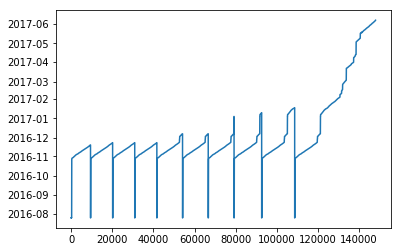

In [22]:
#Visualize DateTime data
plt.plot(A1_MRG_1['DateTime'])

In [24]:
#Find IDs of all data reset locations (find indices of values occuring right before a minimum)
chg_indices = np.asarray(A1_MRG_1.loc[A1_MRG_1['DateTime'] == np.min(A1_MRG_1['DateTime'])].index.tolist())
chg_indices = (chg_indices - 1)
chg_indices = chg_indices[1:12]
A1_MRG_1.iloc[chg_indices,0]

78       2016-07-25 22:55:09
157      2016-07-25 22:55:09
9407     2016-11-19 11:56:52
20160    2016-11-22 23:59:20
30913    2016-11-22 23:59:20
41666    2016-11-22 23:59:20
54158    2016-12-07 06:25:02
66650    2016-12-07 06:25:02
79206    2017-01-03 23:56:03
92631    2017-01-09 23:54:28
108683   2017-01-17 23:59:44
Name: DateTime, dtype: datetime64[ns]

<b>Exploring MRG2

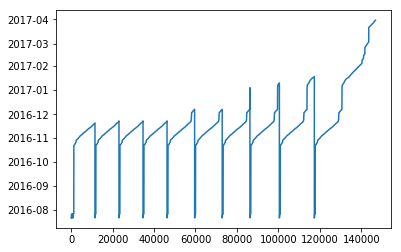

In [34]:
#Visualize DateTime data
plt.plot(A1_MRG_2['DateTime'])

In [35]:
#Find IDs of all data reset locations (find indices of values occuring right before a minimum)
chg_indices_2 = np.asarray(A1_MRG_2.loc[A1_MRG_2['DateTime'] == np.min(A1_MRG_2['DateTime'])].index.tolist())
chg_indices_2 = (chg_indices_2 - 1)
chg_indices_2 = chg_indices_2[1:len(chg_indices_2)]
# chg_indices_2
A1_MRG_2.iloc[chg_indices_2,0]
# A1_MRG_2

415      2016-07-26 23:39:07
831      2016-07-26 23:39:07
11482    2016-11-19 17:54:52
23081    2016-11-22 11:59:45
34680    2016-11-22 11:59:45
46279    2016-11-22 11:59:45
59594    2016-12-07 06:25:00
72909    2016-12-07 06:25:00
86283    2017-01-03 23:55:37
100511   2017-01-09 23:57:48
117381   2017-01-17 23:53:25
Name: DateTime, dtype: datetime64[ns]

<b> Create new dataframe from the last full run

In [41]:
def TSrepeat(df):
    # Find IDs of all data reset locations (find indices of values occuring at minimum)
    chg_indices = np.asarray(df.loc[df['DateTime'] == np.min(df['DateTime'])].index.tolist())
    # Get rid of first minimum (index 0)
    chg_indices = chg_indices[1:]

    # Create sets of indices for each run
    start=0
    chg_indices_set=[]
    for i, ci in enumerate(chg_indices):
        stop = ci
        chg_indices_set.append((start,stop))
        start = stop
    # add index set for final run
    chg_indices_set.append((start,df.shape[0]))
#     print(chg_indices_set)
    # Check if each run 
    for i in range(len(chg_indices_set)-1):
        start0,stop0 = chg_indices_set[i]
        runlength = stop0-start0
        start1 = stop0
        stop1 = runlength+start1
        allMatch = df.iloc[start0:stop0].reset_index(drop=True).equals(df.iloc[start1:stop1].reset_index(drop=True))
#         print(allMatch)
        if not(allMatch):
            print("WARNING: Data is not duplicated between all runs")
            break
        else:
            pass
    if allMatch:
#         print(start1,stop1)
#         return(df.iloc[start1:df.shape[0]].drop('indicator',axis=1).reset_index(drop=True))#.duplicated())
        return(df.drop_duplicates(keep='first').reset_index(drop=True))

In [49]:
A1_MRG1_ts = TSrepeat(A1_MRG_1)

In [15]:
A1_MRG1_ts.shape

(39003, 37)

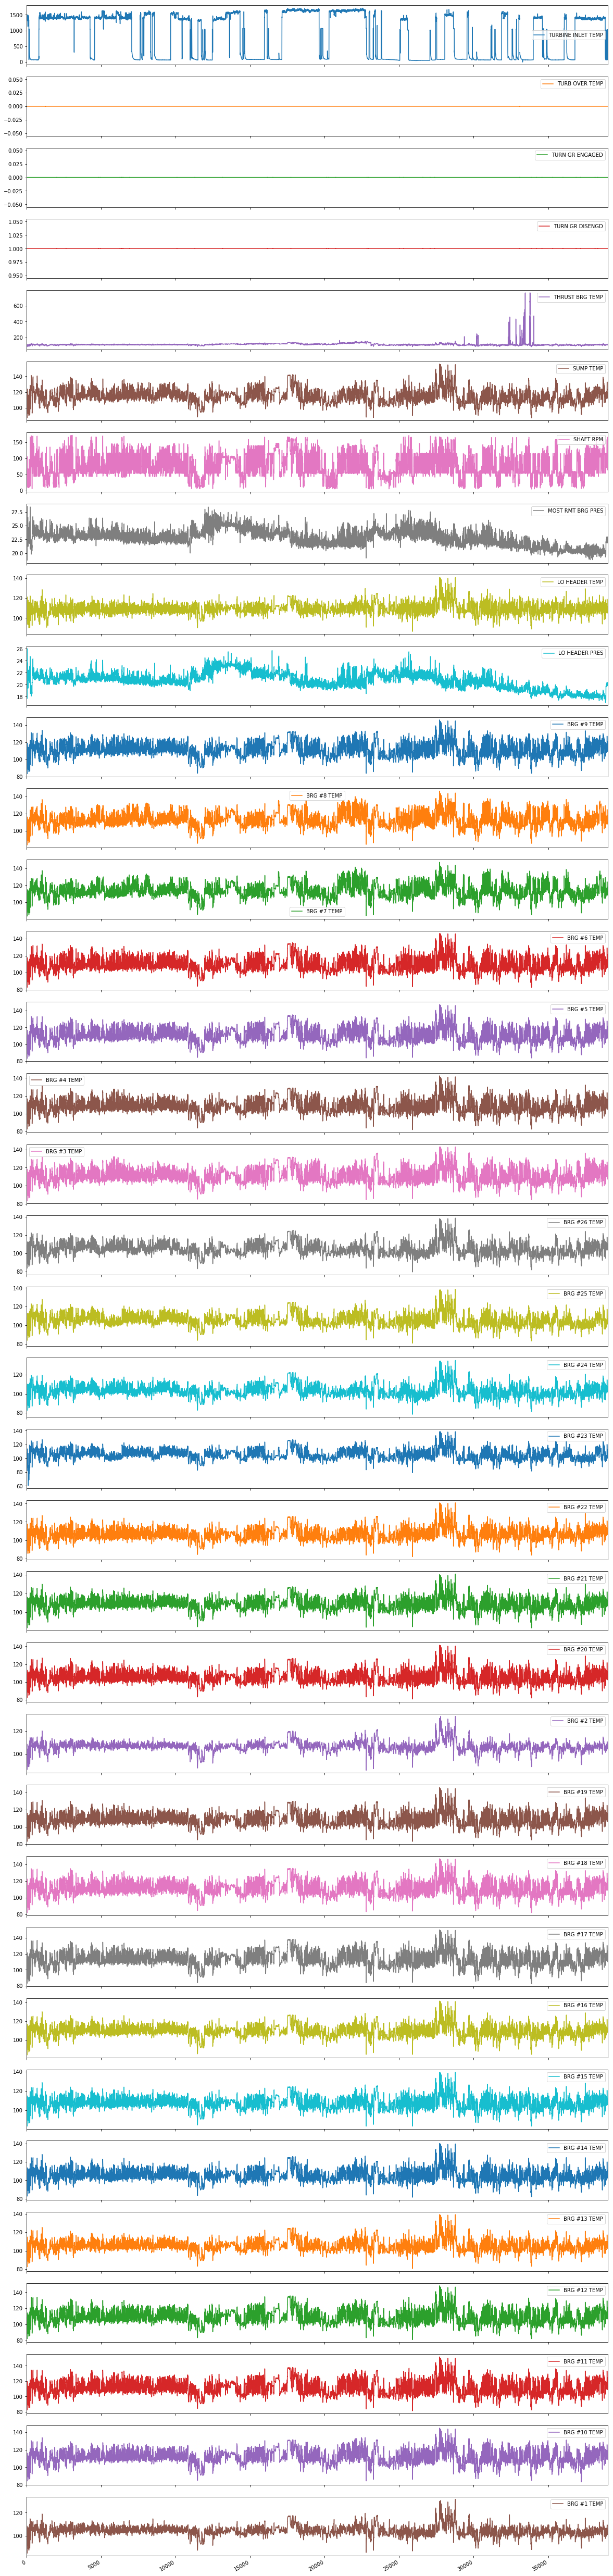

In [36]:
# Time Series Plots
tmp_ts = A1_MRG1_ts.plot(figsize=(20,100),subplots=(37,1)) 

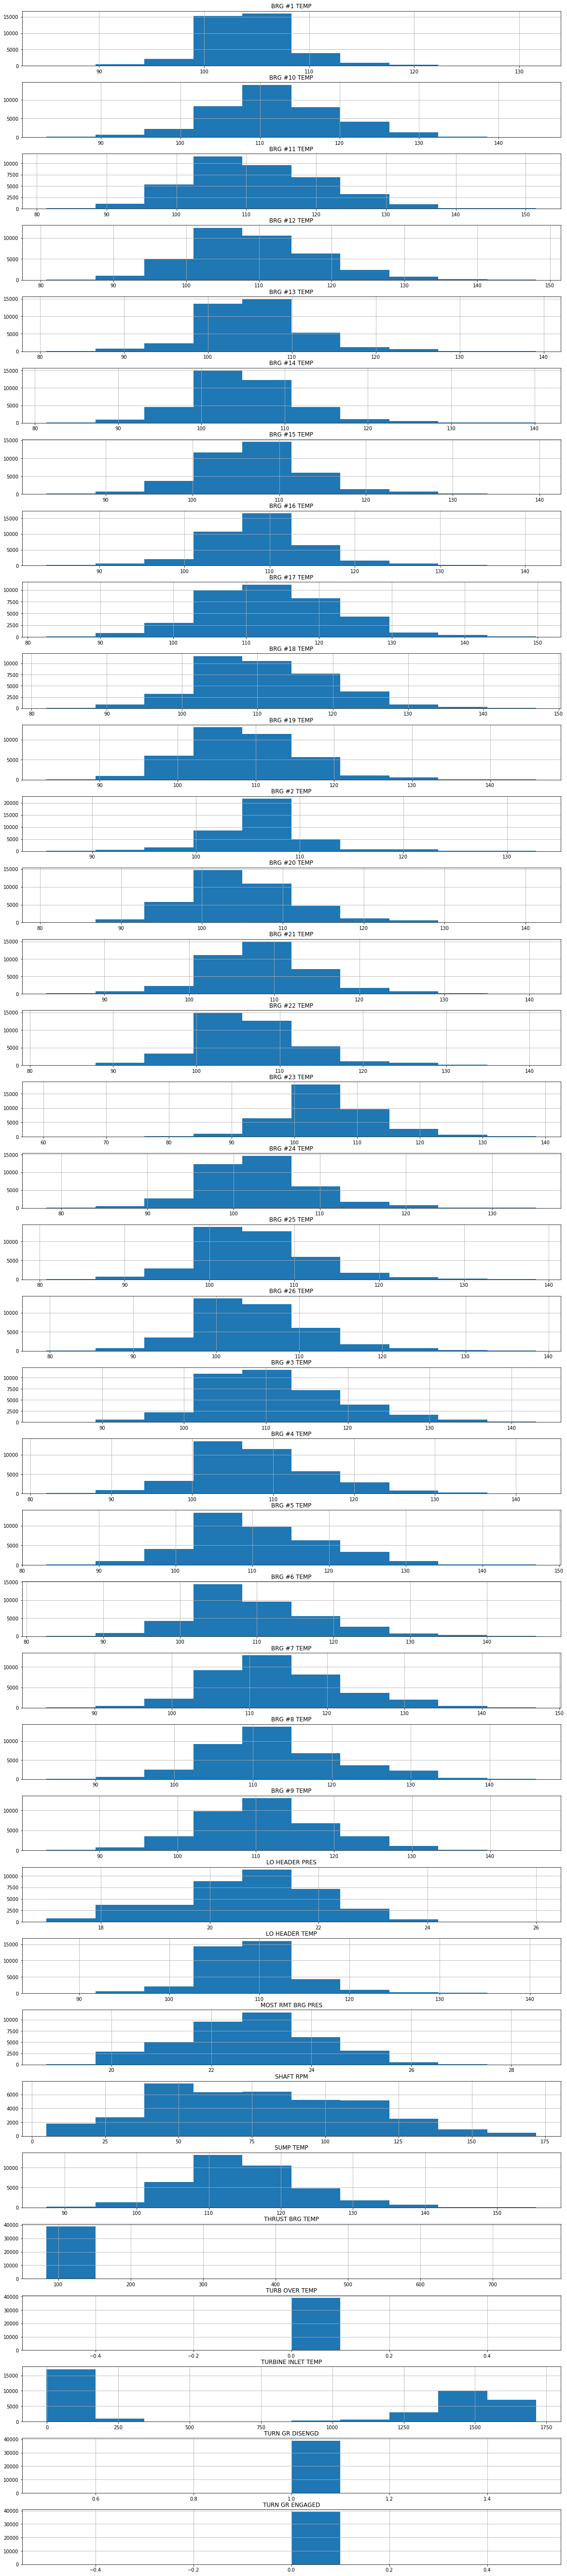

In [28]:
# Histogram Plots
tmp_hist = A1_MRG1_ts.hist(figsize=(20,100),layout=(37,1))   

<b> Create time series and histograms for MRG 2

In [42]:
A1_MRG2_ts = TSrepeat(A1_MRG_2)

In [46]:
A1_MRG2_ts.to_csv(path_or_buf="A1_MRG2.csv",index=False)

In [43]:
A1_MRG2_ts.shape

(29540, 37)

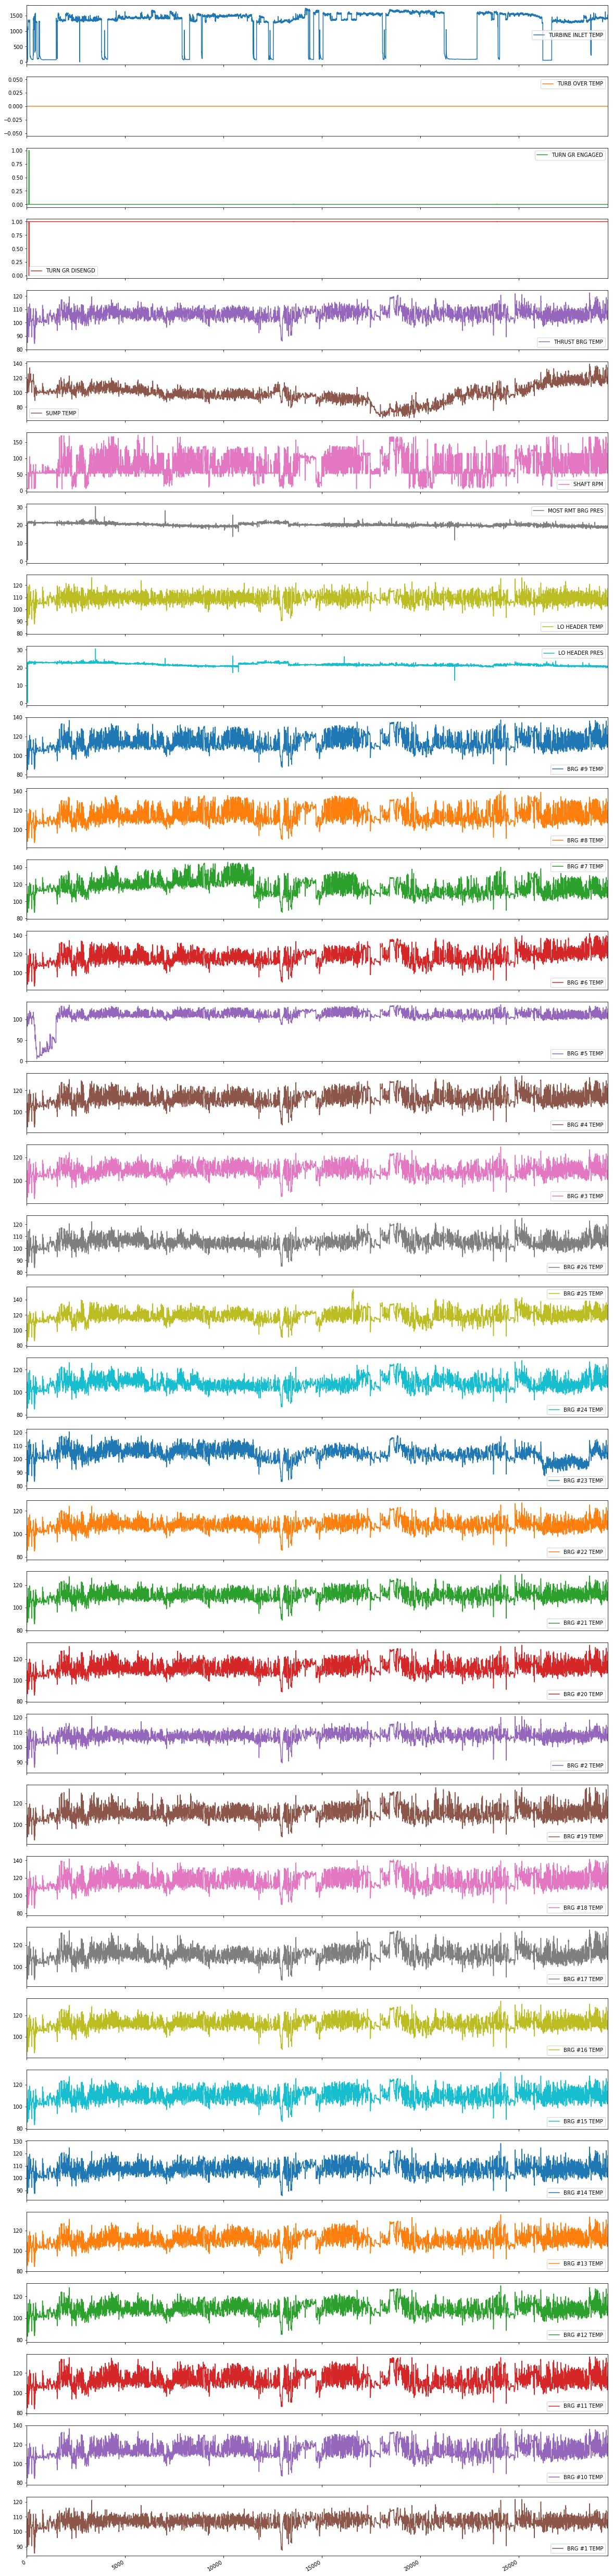

In [44]:
# Time Series Plots
tmp_ts = A1_MRG2_ts.plot(figsize=(20,100),subplots=(37,1)) 

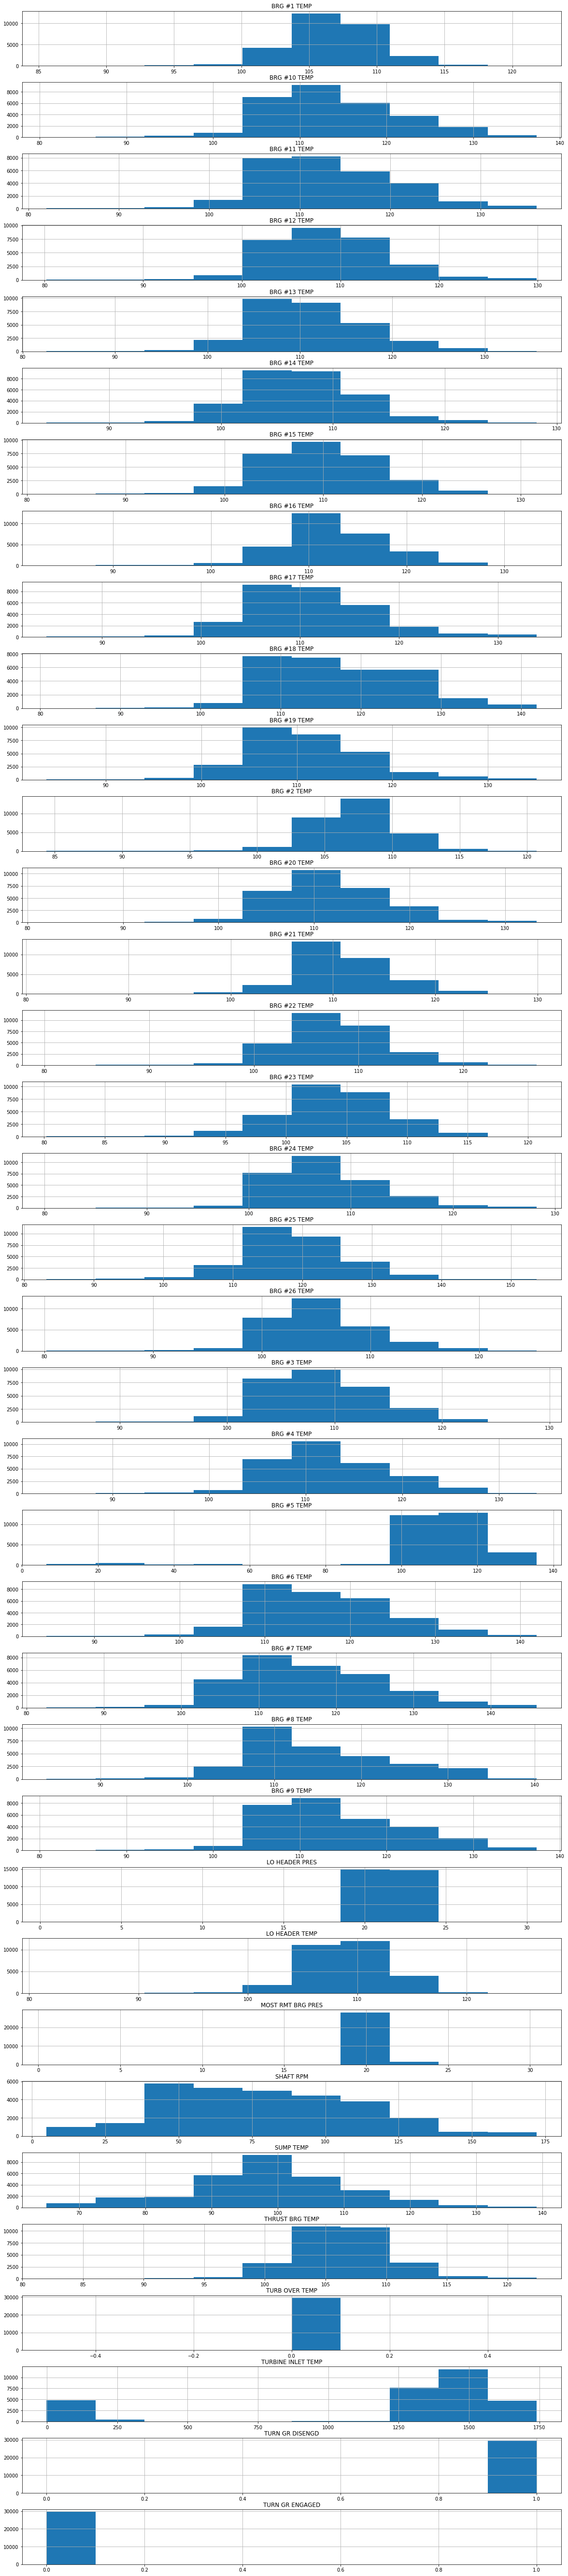

In [45]:
# Histogram Plots
tmp_hist = A1_MRG2_ts.hist(figsize=(20,100),layout=(37,1))   

## Outlier Exploration
For a first look, outlier thresholds are set at $\mu \pm 3 \sigma$

In [47]:
def plotall(df,threshold=3):
    #
    f, axarr = plt.subplots(df.shape[1],1, figsize=(20,75),sharex=True)

    for ii in range(1,df.shape[1]):
        df_inner = df[(np.abs(df.iloc[:,ii]-df.iloc[:,ii].mean())<=(threshold*df.iloc[:,ii].std()))]
        df_outer = df[(np.abs(df.iloc[:,ii]-df.iloc[:,ii].mean())>(threshold*df.iloc[:,ii].std()))]
    #     print(df_outer.iloc[:,[0,ii]])
        axarr[ii].set_title(df.columns.values[ii])
        axarr[ii].plot(df_inner['DateTime'],df_inner.iloc[:,ii],'.b')
        axarr[ii].plot(df_outer['DateTime'],df_outer.iloc[:,ii],'.r')
        axarr[ii].axhline(df.iloc[:,ii].mean()+threshold*df.iloc[:,ii].std(),color='r')
        axarr[ii].axhline(df.iloc[:,ii].mean()-threshold*df.iloc[:,ii].std(),color='r')
    plt.show()

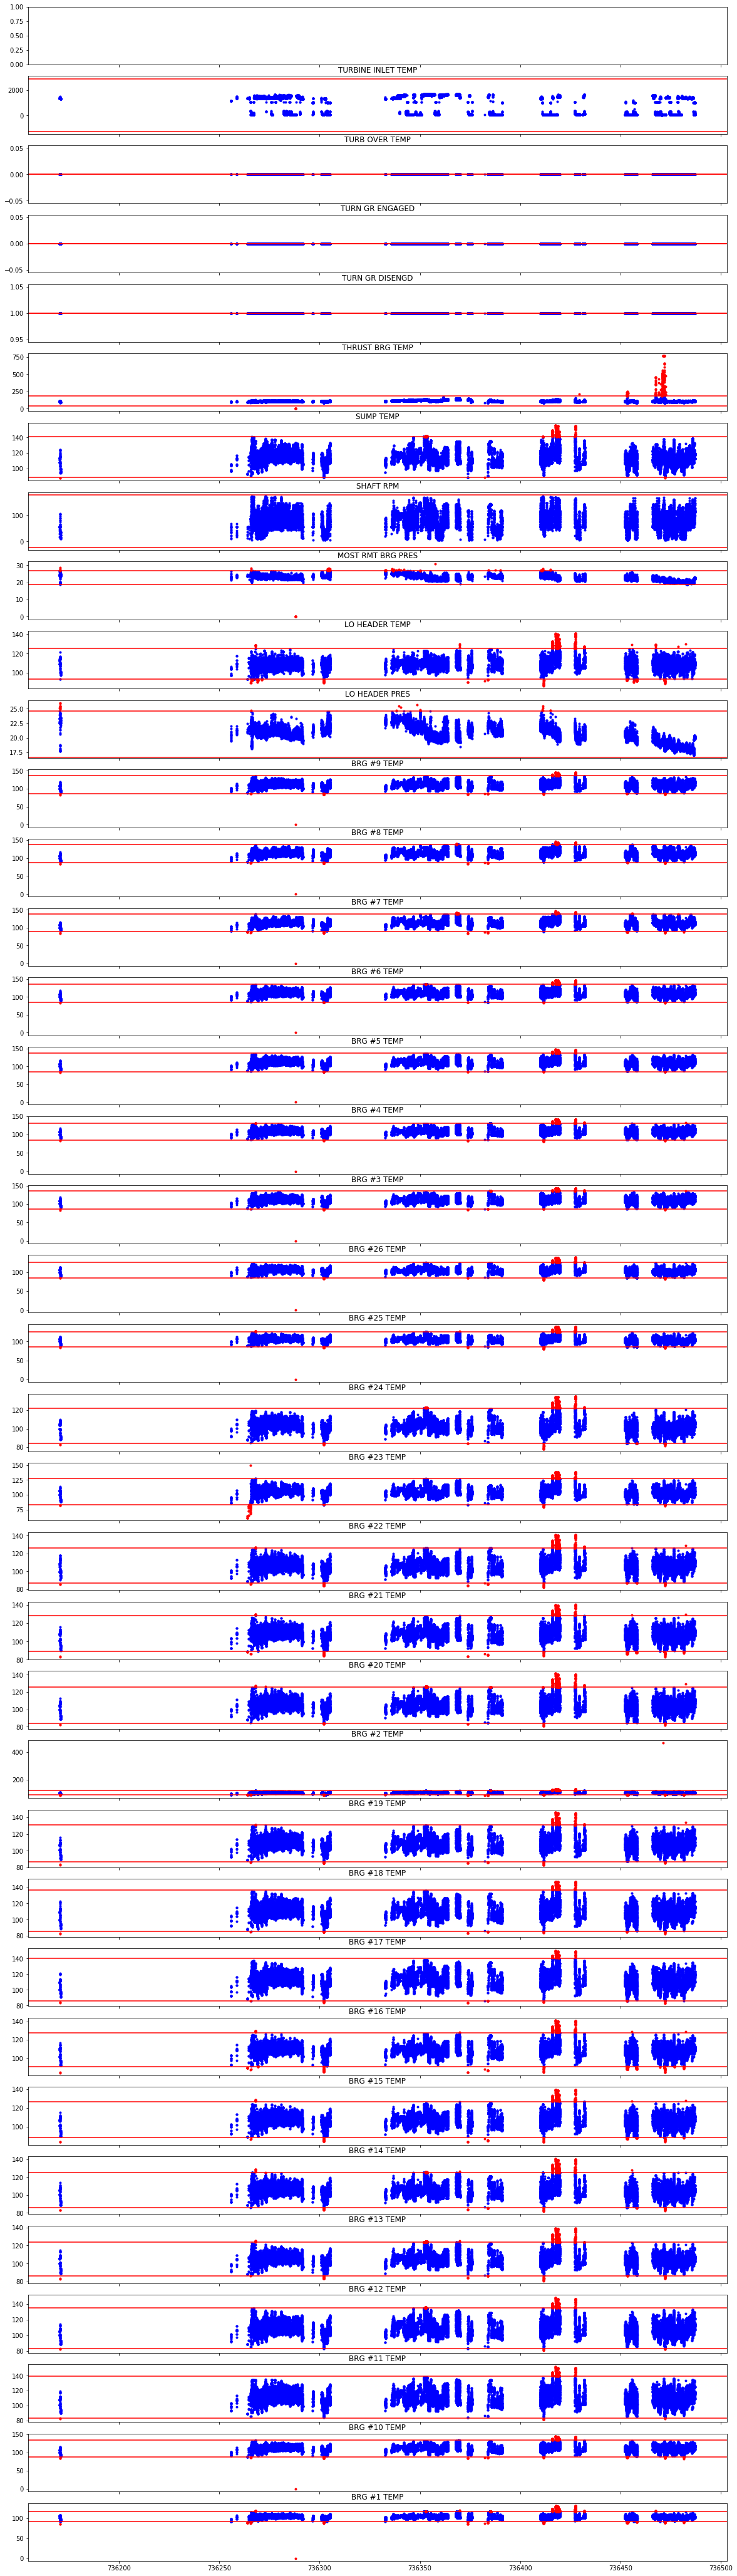

In [50]:
plotall(A1_MRG1_ts,threshold=3)

Some distant outliers are scewing the y-axes on the plots.

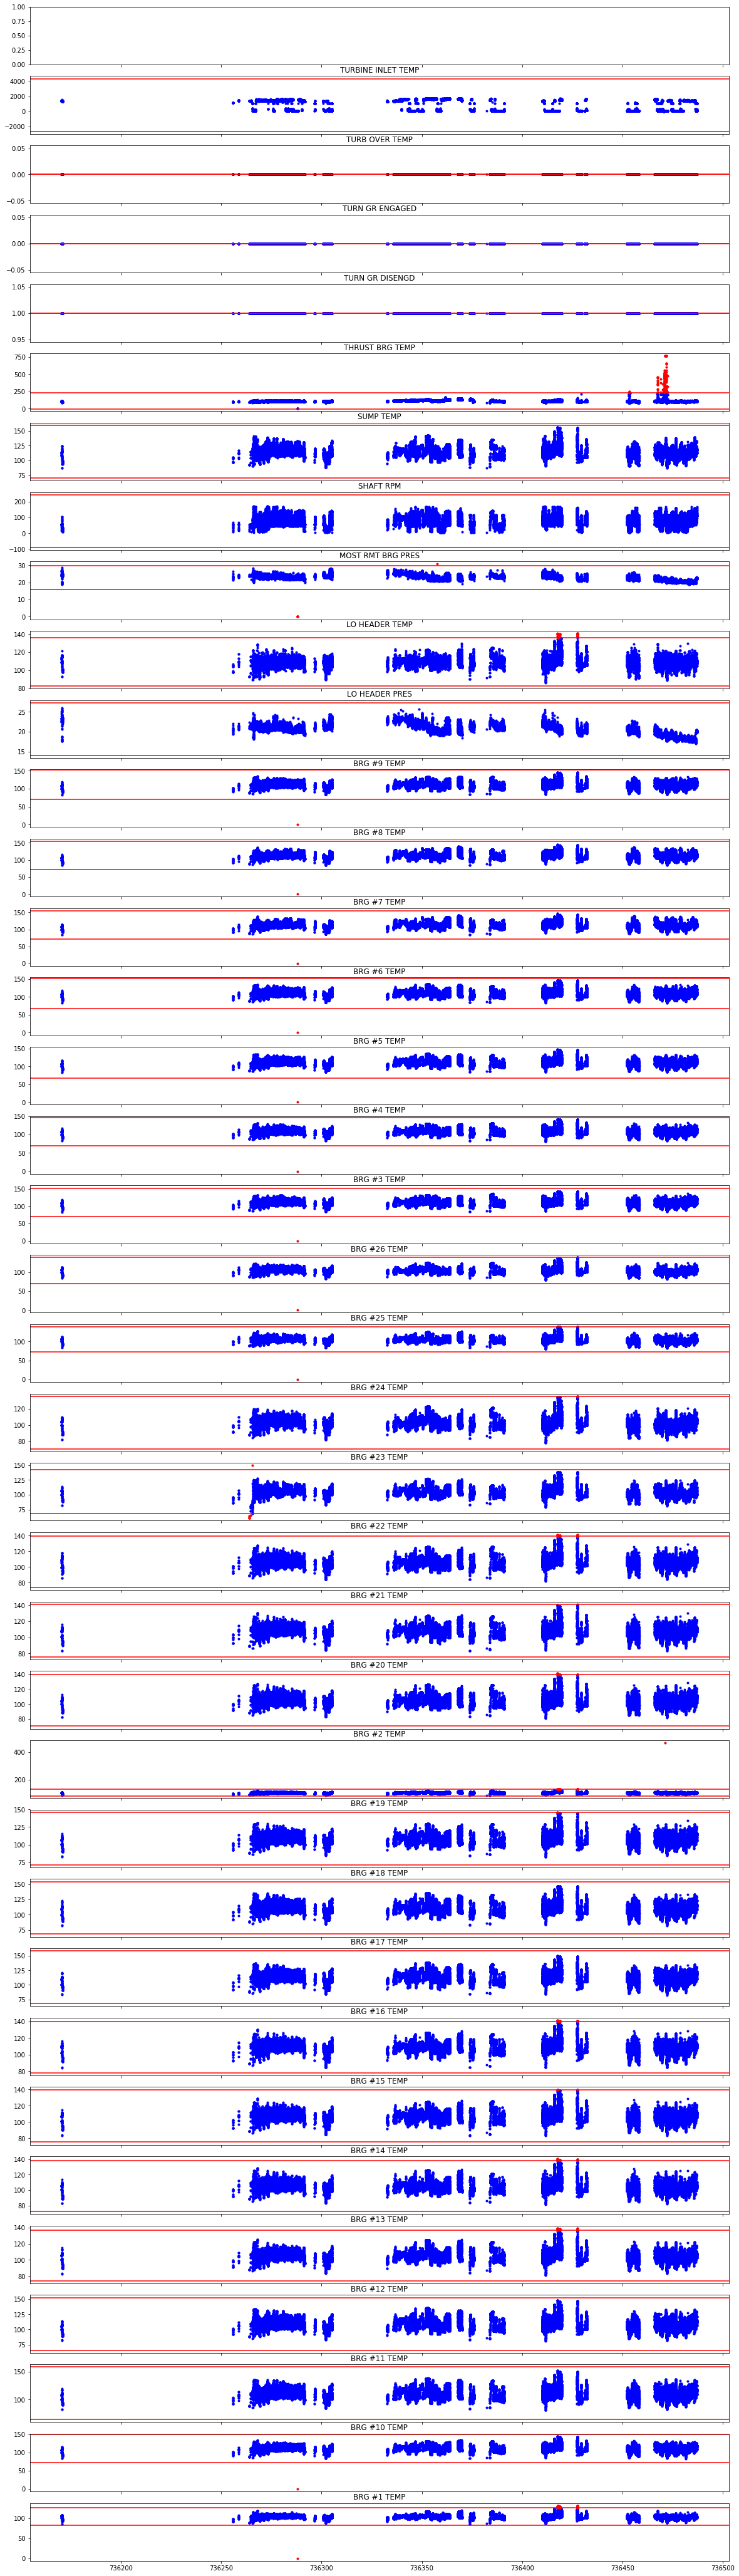

In [51]:
plotall(A1_MRG1_ts,threshold=5)

Setting thresholds at $\mu \pm 5 \sigma$ appears to capture the distant outliers. The tables below lists singular outlier points for the A1_MRG1. 

|      |DateTime             |Value            | Column Name|
|------|---------------------|----------------:|:------------|
|193   |2016-10-28 17:45:02  |       149.199997|  BRG #23 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0| MOST RMT BRG PRES|
|9458  |2016-11-19 22:07:20  |              0.0|  BRG #9 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|  BRG #8 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|  BRG #7 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|  BRG #6 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|  BRG #5 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|  BRG #4 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|  BRG #3 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0| BRG #26 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|BRG #25 TEMP|
|9458  |2016-11-19 22:07:20  |              0.0|BRG #10 TEMP
|9458  |2016-11-19 22:07:20  |              0.0| BRG #1 TEMP|
|9459  |2016-11-19 22:09:42  |              0.0| MOST RMT BRG PRES|
|9460  |2016-11-19 22:09:52  |              0.0| MOST RMT BRG PRES|
|9461  |2016-11-19 22:11:22  |              0.0| MOST RMT BRG PRES|
|9462  |2016-11-19 22:17:16  |              0.0| MOST RMT BRG PRES|
|19738 |2017-01-28 14:39:06  |             30.6| MOST RMT BRG PRES|
|33451 |2017-05-22 01:19:39  |       465.799988|  BRG #2 TEMP|

The above rows are removed from the dataframe.

In [52]:
out_index = [193,9458,9459,9460,9461,9462,19738,33451]
A1_MRG1_ts.drop(out_index,inplace=True)

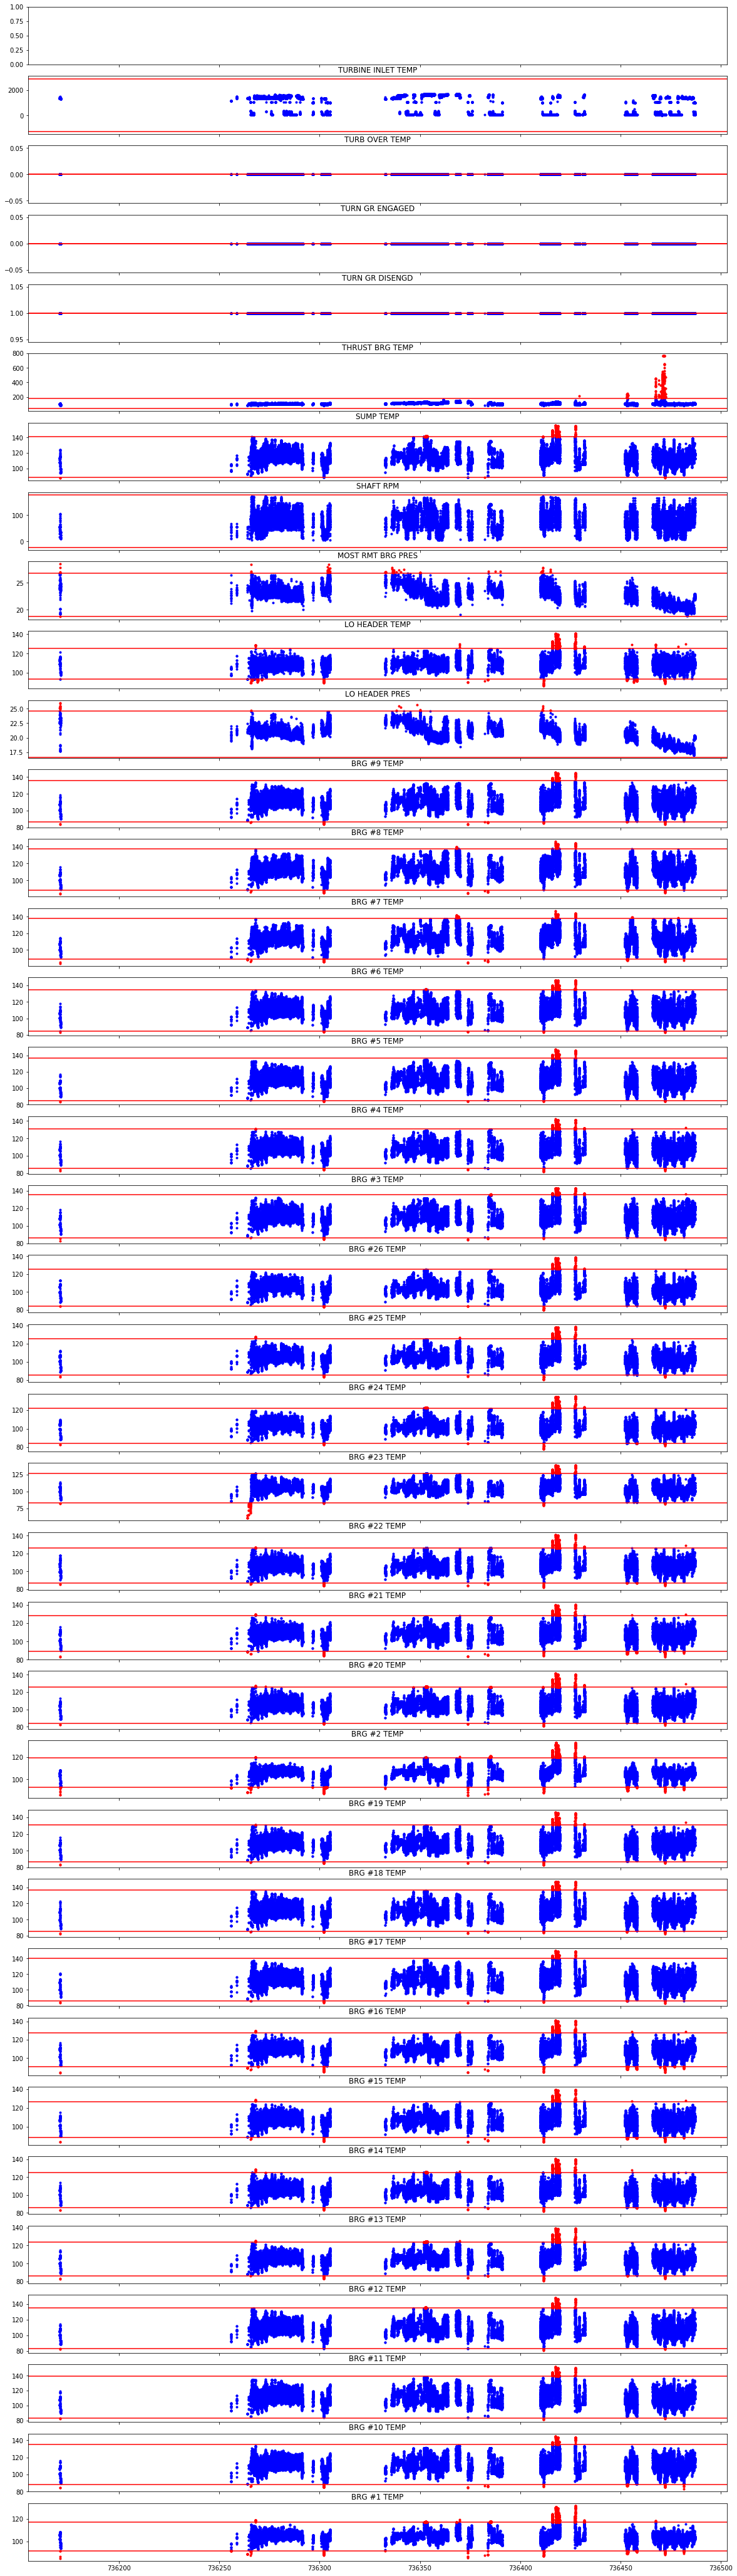

In [53]:
plotall(A1_MRG1_ts,threshold=3)

<b>Outlier Exploration for MRG 2

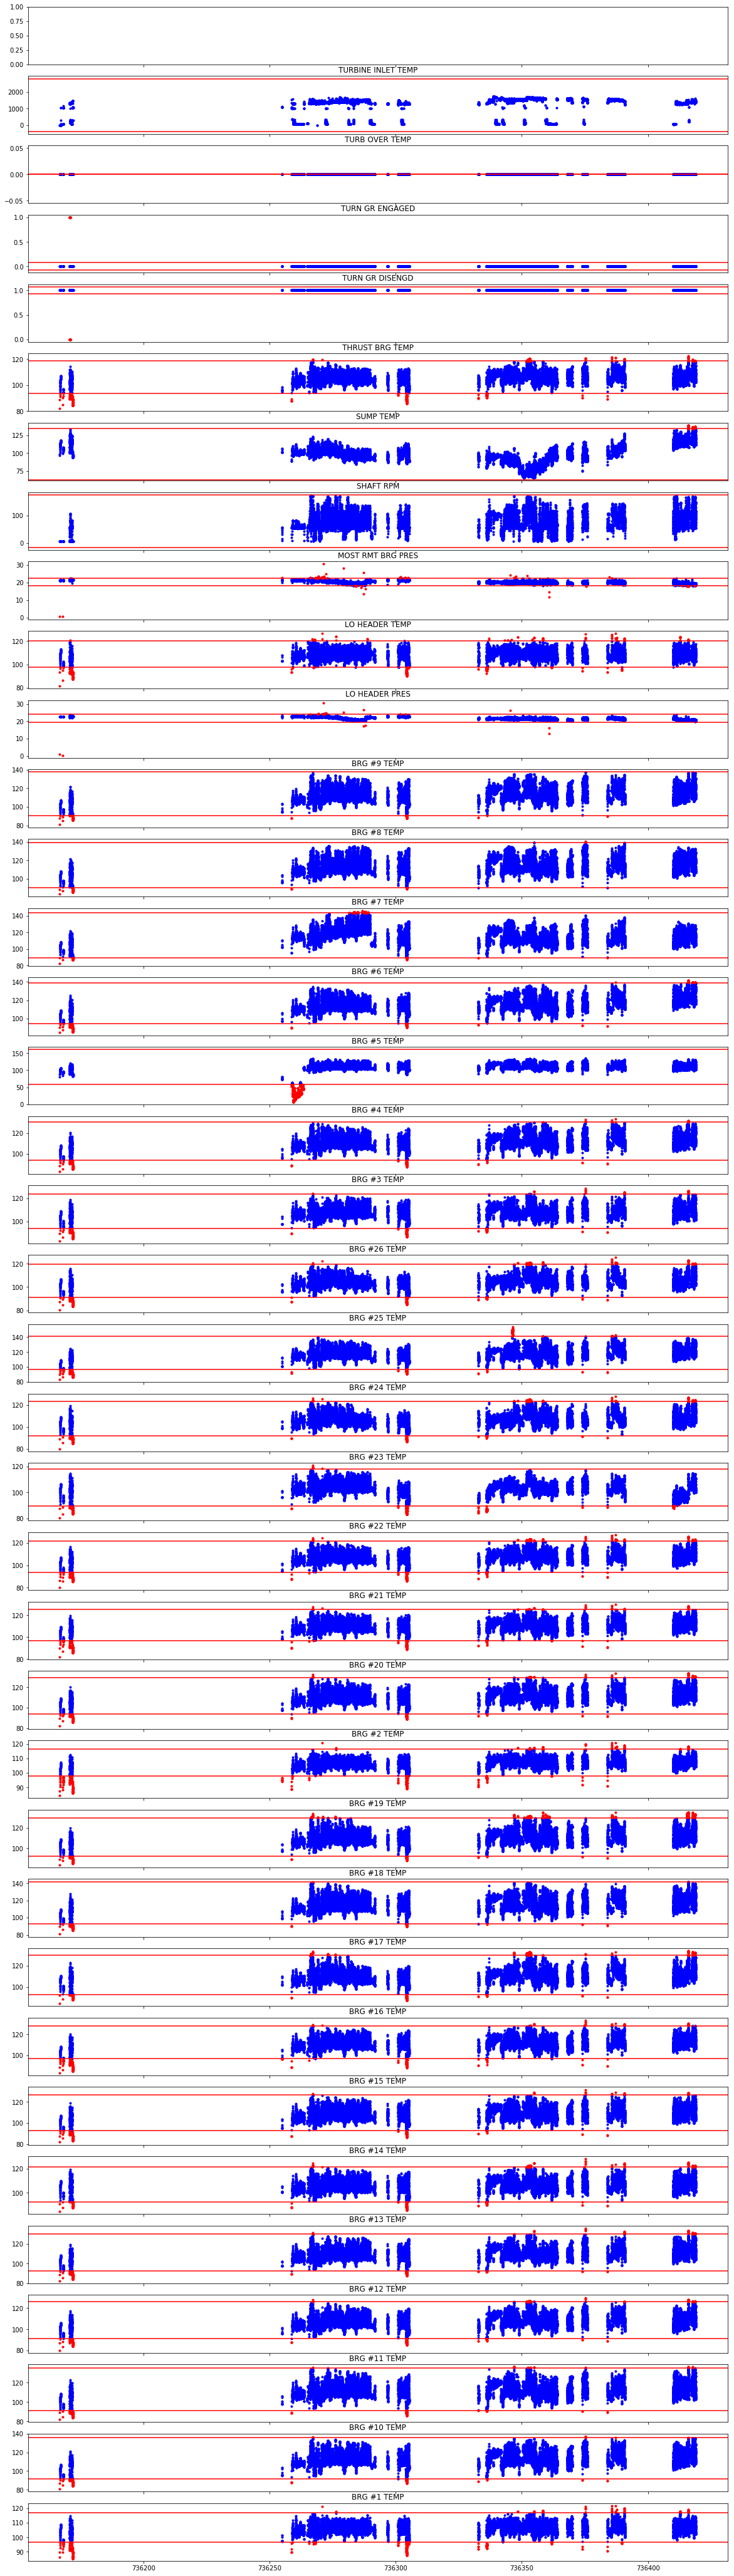

In [54]:
plotall(A1_MRG2_ts,threshold=3)

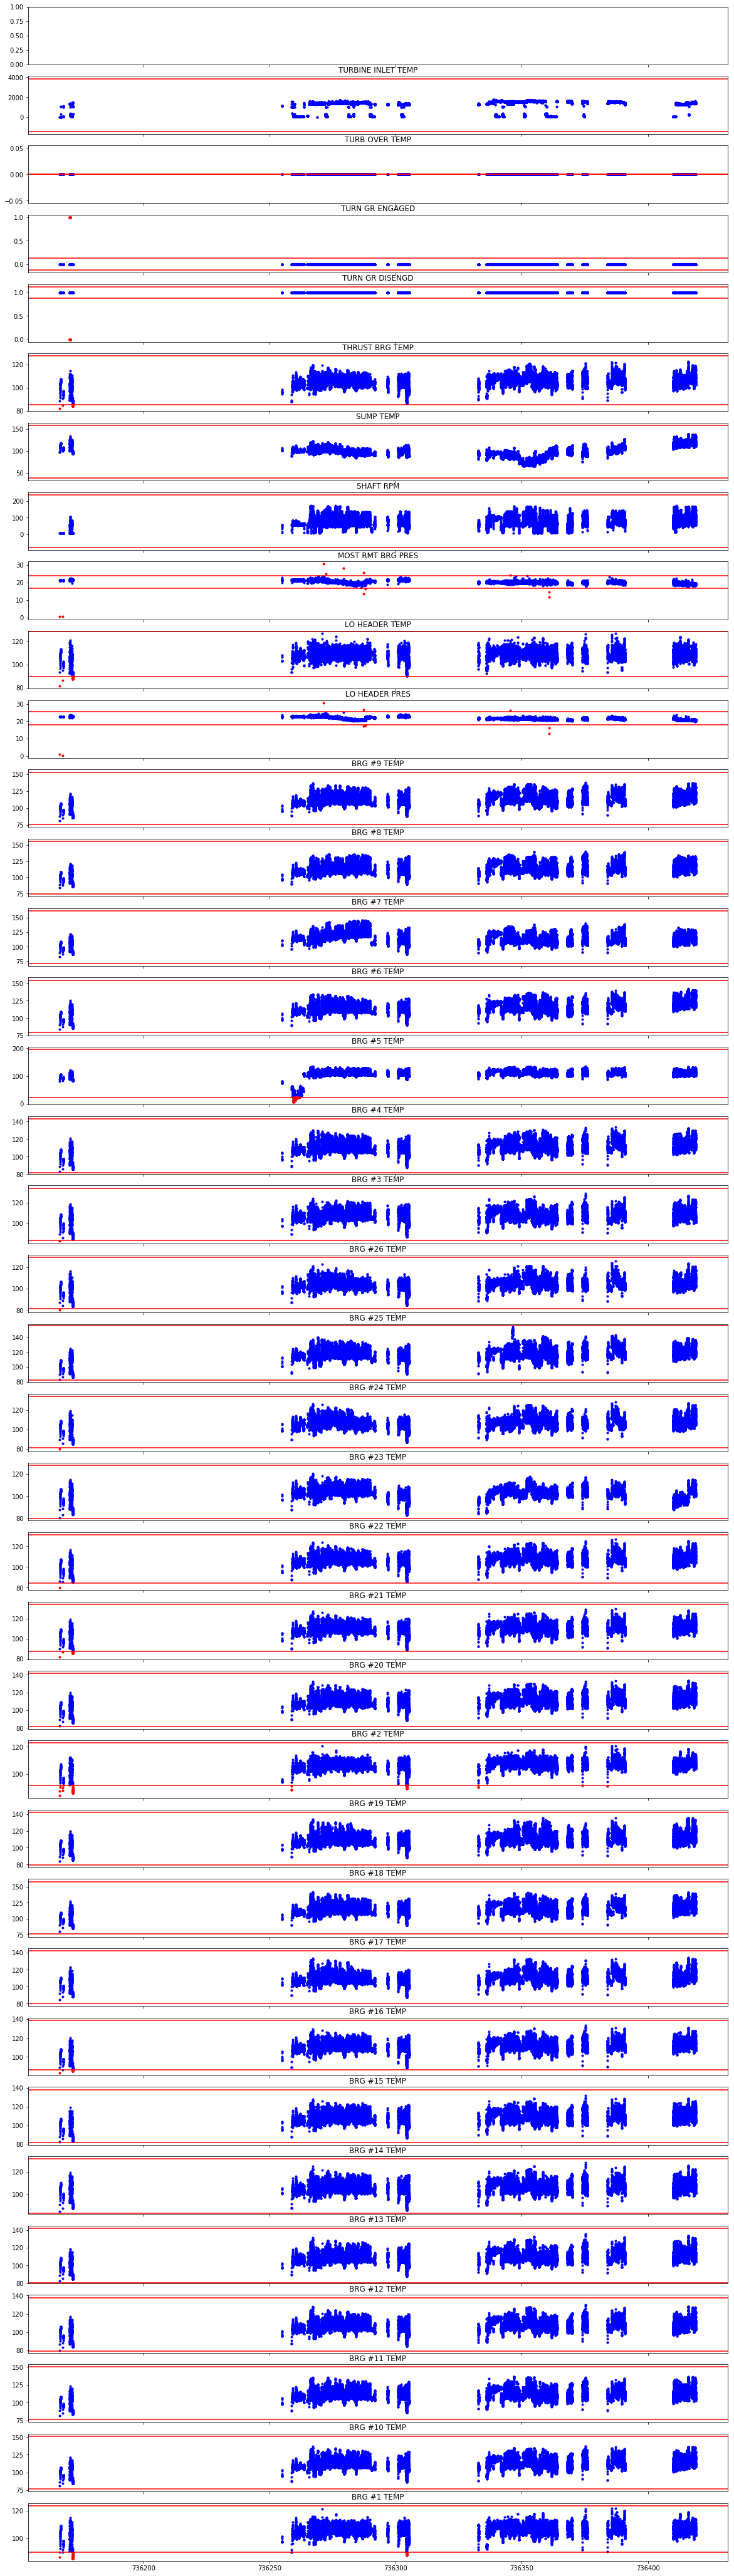

In [55]:
plotall(A1_MRG2_ts,threshold=5)